# 결정 트리

루트 노드에서 시작하여 예/아니오에 대한 질문을 이어나가 리프 노드에 도달한다. 리프노드에서 가장 많은 클래스가 예측 클래스가 된다.

*   로지스틱 회귀에 비해 예측 과정을 이해하기 쉽다
*   특성값의 스케일이 영향을 미치지 않는다 -> 데이터 전처리x

노드는 훈련 데이터의 특성에 대한 테스트를 표현한다. 가지는 테스트의 결과(True, False)를 나타낸다. 노드는 다음과 같은 4가지 정보를 담는다.

1.   테스트 조건: 부모 노드와 자식 노드의 불순도 차이(정보 이득)가 크도록 테스트한다
2.   지니 불순도(gini): 1-(클래스별 비율의 제곱의 합) 으로 이 값이 낮을수록 순수하다
3.   총 샘플 수(samples)
4.   클래스별 샘플 수(value)

---

와인의 알코올 도수, 당도, pH 데이터로 레드 와인/화이트 와인을 분류하는 결정 트리를 구해보자



In [ ]:
## 데이터 준비

# info() 메서드: 데이터프레임의 각 열의 데이터 타입과 누락된 데이터를 확인한다
# describe() 메서드: 열에 대한 간략한 통계를 출력한다

import numpy as np
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

print(wine.info())
print(wine.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB
None
           alcohol        sugar           pH        class
count  6497.000000  6497.000000  6497.000000  6497.000000
mean     10.491801     5.443235     3.218501     0.753886
std       1.192712     4.757804     0.160787     0.430779
min       8.000000     0.600000     2.720000     0.000000
25%       9.500000     1.800000     3.110000     1.000000
50%      10.300000     3.000000     3.210000     1.000000
75%      11.300000     8.100000     3.320000     1.000000
max      14.900000    65.800000     4.010000     1.000000


In [ ]:
from sklearn.model_selection import train_test_split

data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

train_input[:5]


array([[10.5 ,  7.7 ,  3.19],
       [12.4 ,  2.1 ,  3.26],
       [11.8 ,  2.1 ,  3.41],
       [11.7 ,  1.2 ,  3.37],
       [ 9.3 , 15.4 ,  3.11]])

In [ ]:
## DecisionTreeClassifier 클래스: 사이킷런의 결정 트리 모델을 훈련시키는 클래스
# criterion 매개변수: 불순도의 종류를 지정한다 (기본값은 'gini')
# max_depth 매개변수: 트리가 성장할 최대 깊이를 지정한다

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


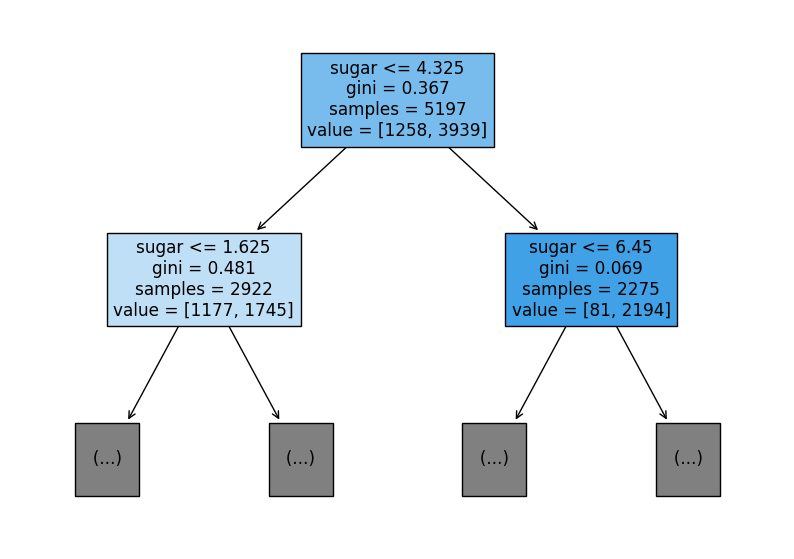

In [ ]:
## polt_tree(모델 객체) 함수: 결정 트리 모델을 트리 그림으로 시각화한다
# max_depth 매개변수: 시각화할 트리의 깊이를 지정한다
# filled 매개변수: 노드에 클래스별 색을 채운다
# feature_names 매개변수: 특성의 이름을 전달한다

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol','sugar','pH'])
plt.show()

# 교차 검증

훈련 세트를 여러 폴드로 나누어 한 폴드를 검증 세트로 활용하여 평가하는 과정을 반복한다. 그다음 이 점수를 평균하여 최종 검증 점수를 얻는다. 교차 검증으로 하이퍼파라미터를 튜닝할 수 있다. 하이퍼파라미터 튜닝 작업은 그리드 서치와 랜덤 서치로 나뉜다.

*   하이퍼파라미터: 사용자가 지정하는 파라미터
*   검증 세트: 하이퍼파라미터 튜닝을 위해 사용하는 데이터 세트 (테스트 세트와 다름)
*   그리드 서치: 나열된 값을 탐색값으로 교차 검증을 진행해 좋은 검증 점수의 매개변수 조합을 선택한다.
*   랜덤 서치: 확률 분포 객체를 탐색값으로 교차 검증을 진행해 좋은 검증 점수의 매개변수 조합을 선택한다.

---

결정 트리의 하이퍼파라미터를 튜닝해보자




In [ ]:
## cross_validate(모델 객체, 입력 데이터, 타깃 데이터) 함수: 교차 검증을 실시하여 모델을 훈련하는 시간, 검증하는 시간, 검증 점수를 반환한다
# cv 매개변수: 폴드 수를 지정한다 or 분할기 클래스를 지정한다

# 분할기 클래스: 교차 검증을 할때 훈련 세트를 섞는다 (회귀-KFold, 분류-StratifiedKFold)
# n_splits 매개변수: 폴드 수를 지정한다

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

dt = DecisionTreeClassifier(random_state=42)
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_validate(dt, train_input, train_target, cv=splitter)

print(scores)
print(np.mean(scores['test_score']))

{'fit_time': array([0.01032257, 0.00944448, 0.00952435, 0.00958014, 0.00917292,
       0.00919914, 0.00913882, 0.00922918, 0.0093801 , 0.00958037]), 'score_time': array([0.00115299, 0.00109792, 0.00108647, 0.00121856, 0.00107241,
       0.00102782, 0.00107288, 0.00107646, 0.00110793, 0.0011065 ]), 'test_score': array([0.83461538, 0.87884615, 0.85384615, 0.85384615, 0.84615385,
       0.87307692, 0.85961538, 0.85549133, 0.85163776, 0.86705202])}
0.8574181117533719


In [ ]:
## GridSearchCV 클래스: 그리드 서치를 수행하는 클래스
## GridSearchCV(모델 객체, 하이퍼파라미터 딕셔너리)
# n_jobs 매개변수: CPU 코어 수를 지정한다. -1로 지정하면 모든 코어를 사용한다.

from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': np.arange(5, 20, 1),
          'min_samples_split': np.arange(2, 100, 10)
          }

gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92])})

In [ ]:
# best_estimator_ 속성: 최적의 하이퍼파라미터로 전체 훈련 세트를 훈련한 모델 객체
# best_params_ 속성: 최적의 하이퍼파라미터 딕셔너리

dt = gs.best_estimator_
print(gs.score(train_input, train_target))

print(gs.best_params_)

0.892053107562055
{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
## 랜덤 서치

# randint 클래스: 균등 분포에서 정숫값을 샘플링한다
# uniform 클래스: 균등 분포에서 실숫값을 샘플링한다
# rvs(n) 메서드: n개를 샘플링하여 반환한다

from scipy.stats import uniform, randint

rgen = randint(0,10)
print(rgen.rvs(10))

ugen = uniform(0,1)
print(ugen.rvs(10))

[2 0 2 4 2 1 9 4 1 3]
[0.47675858 0.95909123 0.61195949 0.30832654 0.62074721 0.61021721
 0.60653967 0.24787676 0.18910347 0.91691412]


In [ ]:
## RandomizedSearchCV 클래스: 랜덤 서치를 수행하는 클래스
## RandomizedSearchCV(모델 객체, 확률 분포 객체를 담은 하이퍼파라미터 딕셔너리)
# n_iter 매개변수: 샘플링 횟수를 지정한다

from sklearn.model_selection import RandomizedSearchCV

params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25)
          }

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

dt = gs.best_estimator_
print(gs.score(train_input, train_target))

print(gs.best_params_)


0.8928227823744468
{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


# 트리의 앙상블

결정 트리의 앙상블 학습은 여러 개의 결정 트리 모델을 훈련하여 평균하는 알고리즘이다. 정형 데이터의 머신러닝 알고리즘 중에서 가장 성과가 뛰어나다.


1.   랜덤 포레스트: 부트스트랩 샘플을 사용하고 랜덤하게 일부 특성을 선택하여 트리를 만든다.
2.   엑스트라 트리: 랜덤 포레스트와 비슷하지만, 전체 훈련 샘플을 사용하고 노드를 랜덤으로 분할한다.
3.   그레이디언트 부스팅: 깊이가 얕은 결정 트리를 연속적으로 추가하여 경사하강법으로 손실함수를 최소화한다.
4.   히스토그램 기반 그레이디언트 부스팅: 그레이디언트 부스팅의 속도를 개선한 알고리즘이다.



In [ ]:
## 1. 랜덤 포레스트
## RandomForestClassifier 클래스: 랜덤 포레스트 알고리즘을 진행한다

# n_estimators 매개변수: 훈련시킬 트리의 개수를 지정한다
# return_train_score 매개변수: True로 지정하면 train_score(훈련 세트 점수)도 반환한다

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(scores, '\n')
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

{'fit_time': array([0.80923772, 0.78932548, 0.84151626, 0.81519747, 0.67246556]), 'score_time': array([0.0664928 , 0.05972409, 0.12260389, 0.10141158, 0.05769682]), 'test_score': array([0.88461538, 0.88942308, 0.90279115, 0.88931665, 0.88642926]), 'train_score': array([0.9971133 , 0.99663219, 0.9978355 , 0.9973545 , 0.9978355 ])} 

0.9973541965122431 0.8905151032797809


In [ ]:
# feature_importances 속성: 특성 중요도를 저장한다

rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


In [ ]:
# oob_score 매개변수: True로 지정하면 각 결정 트리의 OOB 점수를 평균하여 반환한다
# (OOB 점수:부트스트랩 샘플에 사용이 안되고 남은 샘플인 OOB 샘플로 결정 트리를 평가한 점수)

rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


In [ ]:
## 2. 엑스트라 트리
## ExtraTreesClassifier 클래스: 엑스트라 트리 알고리즘을 진행한다

# n_estimators 매개변수: 훈련시킬 트리의 개수를 지정한다

from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [ ]:
## 3. 그레이디언트 부스팅
## GradientBoostingClassifier 클래스: 그레이디언트 부스팅 알고리즘을 진행한다

# n_estimators 매개변수: 부스팅 단계를 수행할 트리의 개수를 지정한다
# learning_rate 매개변수: 트리가 앙상블에 기여하는 정도를 지정한다
# subsample 매개변수: 훈련에 사용할 훈련 세트의 비율을 지정한다

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [ ]:
## 4. 히스토그램 기반 그레이디언트 부스팅
## HistGradientBoostingClassifier 클래스: 히스토그램 기반 그레이디언트 부스팅 알고리즘을 진행한다

# max_iter 매개변수: 트리의 개수를 지정한다 (n_estimators가 아님)
# learning_rate 매개변수: 트리가 앙상블에 기여하는 정도를 지정한다

from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9321723946453317 0.8801241948619236


In [ ]:
# permutatin_importance() 함수: 특성을 랜덤하게 섞어서 모델의 성능 변화를 관찰하여 특성의 중요도를 계산한다
# n_repeats 매개변수: 랜덤하게 섞을 횟수를 지정한다

from sklearn.inspection import permutation_importance

hgb.fit(train_input, train_target)
result = permutation_importance(hgb, train_input, train_target, n_repeats=10, random_state=42, n_jobs=-1)

print(result.importances_mean)


[0.08876275 0.23438522 0.08027708]
